# Import Libraries


In [1]:
import numpy as np
import pandas as pd

from seglearn.pipe import Pype
from seglearn.transform import FeatureRep, Segment
#from seglearn.feature_functions import mean, var, std, skew, kurt
from seglearn.feature_functions import base_features, all_features, hudgins_features, emg_features

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, GroupKFold, cross_validate
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score

import matplotlib.pyplot as plt

import random
import itertools

from joblib import dump, load
#%matplotlib notebook

# Importing the Data

In [2]:
FB_data_path = "./Data/Fanis_Balaskas/accel_gyro.csv"
GV_data_path = "./Data/George_Vardakas/accel_gyro_Geo.csv"
ΤT_data_path = "./Data/George_Vardakas/accel_gyro_Ted.csv"
GP_data_path = "./Data/George_Vardakas/accel_gyro_Gregory.csv"
BRO_data_path = "./Data/George_Vardakas/accel_gyro_Bro.csv"
VD_data_path = "./Data/Vagelis_Dimoulis/accel_gyro.csv"


df_FB_accel_gyro = pd.read_csv(FB_data_path)
df_GV_accel_gyro = pd.read_csv(GV_data_path)
df_TT_accel_gyro = pd.read_csv(ΤT_data_path)
df_GP_accel_gyro = pd.read_csv(GP_data_path)
df_BRO_accel_gyro = pd.read_csv(BRO_data_path)
df_VD_accel_gyro = pd.read_csv(VD_data_path)

In [3]:
# Den exw ta ms gia na spasw to shma se kathgories
datetime_format = "%Y-%m-%d %H:%M:%S.%f"
df_FB_accel_gyro["TIMESTAMP"] = pd.to_datetime(df_FB_accel_gyro["TIMESTAMP"])#, format=datetime_format)
df_GV_accel_gyro["TIMESTAMP"] = pd.to_datetime(df_GV_accel_gyro["TIMESTAMP"])#, format=datetime_format)
df_TT_accel_gyro["TIMESTAMP"] = pd.to_datetime(df_TT_accel_gyro["TIMESTAMP"])
df_GP_accel_gyro["TIMESTAMP"] = pd.to_datetime(df_GP_accel_gyro["TIMESTAMP"])
df_BRO_accel_gyro["TIMESTAMP"] = pd.to_datetime(df_BRO_accel_gyro["TIMESTAMP"])
df_VD_accel_gyro["TIMESTAMP"] = pd.to_datetime(df_VD_accel_gyro["TIMESTAMP"])

## Find when activity changes

In [4]:
# Sampling frequency of accelerometer and gyroscope (10 Hz)
sampling_frequency = df_FB_accel_gyro.loc[1, "TIMESTAMP"] - df_FB_accel_gyro.loc[0, "TIMESTAMP"]

# Finding the indexs where the samples differ more than sampling frequency
df_FB_activity_cutoff = df_FB_accel_gyro.loc[df_FB_accel_gyro["TIMESTAMP"] - df_FB_accel_gyro["TIMESTAMP"].shift() > sampling_frequency]
df_GV_activity_cutoff = df_GV_accel_gyro.loc[df_GV_accel_gyro["TIMESTAMP"] - df_GV_accel_gyro["TIMESTAMP"].shift() > sampling_frequency]
df_TT_activity_cutoff = df_TT_accel_gyro.loc[df_TT_accel_gyro["TIMESTAMP"] - df_TT_accel_gyro["TIMESTAMP"].shift() > sampling_frequency]
df_GP_activity_cutoff = df_GP_accel_gyro.loc[df_GP_accel_gyro["TIMESTAMP"] - df_GP_accel_gyro["TIMESTAMP"].shift() > sampling_frequency]
df_BRO_activity_cutoff = df_BRO_accel_gyro.loc[df_BRO_accel_gyro["TIMESTAMP"] - df_BRO_accel_gyro["TIMESTAMP"].shift() > sampling_frequency]
df_VD_activity_cutoff = df_VD_accel_gyro.loc[df_VD_accel_gyro["TIMESTAMP"] - df_VD_accel_gyro["TIMESTAMP"].shift() > sampling_frequency]

In [5]:
#ax = df_GV_accel_gyro[["ACTIVITY_ID", "ACCEL_X", "ACCEL_Y", "ACCEL_Z"]].plot(figsize = (15, 8))
#ax.vlines(df_GV_activity_cutoff.index, ymin=-20, ymax=120)

In [6]:
#ax = df_FB_accel_gyro[["ACTIVITY_ID", "ACCEL_X", "ACCEL_Y", "ACCEL_Z"]].plot(figsize = (15, 8))
#ax.vlines(df_FB_activity_cutoff.index, ymin=-20, ymax=120)

In [7]:
#ax = df_VD_accel_gyro[["ACTIVITY_ID", "ACCEL_X", "ACCEL_Y", "ACCEL_Z"]].plot(figsize = (15, 8))
#ax.vlines(df_VD_activity_cutoff.index, ymin=-20, ymax=120)

In [8]:
#ax = df_TT_accel_gyro[["ACTIVITY_ID", "ACCEL_X", "ACCEL_Y", "ACCEL_Z"]].plot(figsize = (15, 8))
#ax.vlines(df_TT_activity_cutoff.index, ymin=-20, ymax=120)

In [9]:
#ax = df_GP_accel_gyro[["ACTIVITY_ID", "ACCEL_X", "ACCEL_Y", "ACCEL_Z"]].plot(figsize = (15, 8))
#ax.vlines(df_GP_activity_cutoff.index, ymin=-20, ymax=120)

In [10]:
#ax = df_BRO_accel_gyro[["ACTIVITY_ID", "ACCEL_X", "ACCEL_Y", "ACCEL_Z"]].plot(figsize = (15, 8))
#ax.vlines(df_BRO_activity_cutoff.index, ymin=-20, ymax=120)

## Making one dataframe for all users

In [11]:
df_FB_accel_gyro["USER_ID"] = 0
df_GV_accel_gyro["USER_ID"] = 1
df_VD_accel_gyro["USER_ID"] = 2
df_TT_accel_gyro["USER_ID"] = 3
df_GP_accel_gyro["USER_ID"] = 4
df_BRO_accel_gyro["USER_ID"] = 5

In [12]:
df_accel_gyro = df_FB_accel_gyro.append(df_GV_accel_gyro)
df_accel_gyro = df_accel_gyro.append(df_VD_accel_gyro)
df_accel_gyro = df_accel_gyro.append(df_TT_accel_gyro)
df_accel_gyro = df_accel_gyro.append(df_GP_accel_gyro)
df_accel_gyro = df_accel_gyro.append(df_BRO_accel_gyro)
df_accel_gyro.reset_index(inplace=True)
del df_FB_accel_gyro, df_GV_accel_gyro, df_VD_accel_gyro, df_TT_accel_gyro, df_GP_accel_gyro

In [13]:
sampling_frequency = df_accel_gyro.loc[1, "TIMESTAMP"] - df_accel_gyro.loc[0, "TIMESTAMP"]
# Finding the indexs where the samples differ more than sampling frequency
activities = df_accel_gyro.loc[df_accel_gyro['TIMESTAMP'] - df_accel_gyro['TIMESTAMP'].shift() > sampling_frequency]
# To include the last activity to the end
activities = activities.append(df_accel_gyro.iloc[-1])

# Constracting the data exactly how the seglearn needs it
# Data must be list(np.arrays)
# list() -> single multivariate time series
# X[0].shape -> (n_samples, n_variables)
# n_samples is how many data points we have in time we have
# n_variables is how many sensors we have

# I do not include the moment where activity changes
X = list()
y = list()
groups = list()
low_index = 0

# Use this to throw some samples or not?
samples_to_throw = 10

for i, high_index in enumerate(activities.index):
    low_index += samples_to_throw
    high_index -= samples_to_throw
    data = df_accel_gyro[["ACCEL_X","ACCEL_Y", "ACCEL_Z", "GYRO_X", "GYRO_Y", "GYRO_Z"]].iloc[low_index : high_index]
    data = data.to_numpy()
    labels = df_accel_gyro["ACTIVITY_ID"].iloc[low_index]
    user_id = df_accel_gyro["USER_ID"].iloc[low_index]
    
    X.append(data)
    y.append(labels)
    groups.append(user_id)
    
    #print(low_index, mid_index, high_index)
    low_index = high_index

In [14]:
#ax = df_accel_gyro[["ACCEL_X","ACCEL_Y", "ACCEL_Z", "GYRO_X", "GYRO_Y", "GYRO_Z", "ACTIVITY_ID", "USER_ID"]].plot(figsize=(15,8))
#ax.vlines(activities.index, ymin=-20, ymax=120)

In [15]:
df_accel_gyro.iloc[-1]

index                               34799
TIMESTAMP      2021-01-27 22:59:23.771000
ACCEL_X                          -9.20718
ACCEL_Y                          -2.10337
ACCEL_Z                            2.3823
GYRO_X                         -0.0138483
GYRO_Y                                  0
GYRO_Z                         -0.0106525
ACTIVITY_ID                           103
USER_ID                                 5
Name: 460799, dtype: object

# Defining the features and the pipeline

In [16]:
pipeline = Pype([
    ("segment", Segment()),
    # 120 features are created
    ("features", FeatureRep(features = {**base_features(), **emg_features()})),
    #("features", FeatureRep(features = base_features())),
    ("scaler", StandardScaler()),
    ("pca", PCA()),
    ("rf", RandomForestClassifier())
], memory=None)

/home/geo/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass memory=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/geo/.local/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


## Hyperparameter tuning

In [17]:
splitter = GroupKFold(n_splits=6)
cv = splitter.split(X, y, groups)

parameters_grid = {"segment__width": list(range(250, 400, 50)),
                   "segment__overlap": np.arange(0.1, 0.3, 0.1).tolist(),
                   "pca__n_components" : [70, 80, 90], #[100, 110, 120],
                   "rf__n_estimators": range(20, 45, 5)
                  }

# scoring does not work for some reason
# it maybe always say the big category for each fragment
# scoring="accuracy", maybe because random forest has out of bag error 
grid_search = GridSearchCV(pipeline, parameters_grid, cv=cv, n_jobs=-1)
grid_search.fit(X, y)

print(grid_search.best_score_)
print(grid_search.best_estimator_)

/home/geo/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass memory=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/geo/.local/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/home/geo/.local/lib/python3.6/site-packages/seglearn/transform.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for i in np.arange(N)])


0.7291101832999011
Pype(steps=[('segment', Segment(overlap=0.2, width=300)),
            ('features',
             FeatureRep(features={'abs_energy': <function abs_energy at 0x7f1afb06eae8>,
                                  'emg_var': <function emg_var at 0x7f1afb0709d8>,
                                  'integrated_emg': <function abs_sum at 0x7f1afb06ea60>,
                                  'kurt': <function kurt at 0x7f1afb06ef28>,
                                  'max': <function maximum at 0x7f1afb06ee18>,
                                  'mean': <function mean at 0x7f1afb06e7b8>,
                                  '...
                                  'slope_sign_changes': slope_sign_changes(threshold=0),
                                  'std': <function std at 0x7f1afb06eb70>,
                                  'var': <function var at 0x7f1afb06ebf8>,
                                  'waveform_length': <function waveform_length at 0x7f1afb070510>,
                          

## Cross validation on the best model

In [18]:
best_estimator = grid_search.best_estimator_

cv = splitter.split(X, y, groups)

results = cross_validate(best_estimator, X, y, cv=cv, n_jobs=-1)
results

/home/geo/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass memory=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/geo/.local/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


{'fit_time': array([1.02560592, 0.97398257, 0.98896384, 1.18675256, 1.13946199,
        1.07667351]),
 'score_time': array([0.13845968, 0.12918591, 0.15867758, 0.0320394 , 0.03854394,
        0.07589316]),
 'test_score': array([0.75418994, 0.53023256, 0.84339623, 0.61538462, 0.81021898,
        0.59433962])}

In [19]:
def plot_confusion_matrix(cm, classes, fold, normalize=True, cmap=plt.cm.Blues):
    title = "Confusion matrix " + str(fold)
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize = (15, 8))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.title(title, fontsize=15)
    plt.ylabel("True label", fontsize=15)
    plt.xlabel("Predicted label", fontsize=15)
    plt.tight_layout()
    #plt.savefig(graphs_path + title, facecolor = "#E0E0E0")
    plt.show()

## Creating the confusion matrix for each fold

/home/geo/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/geo/.local/lib/python3.6/site-packages/seglearn/transform.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for i in np.arange(N)])


(590, 6)


/home/geo/.local/lib/python3.6/site-packages/seglearn/transform.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for i in np.arange(N)])
/home/geo/.local/lib/python3.6/site-packages/seglearn/transform.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for i in np.arange(N)])


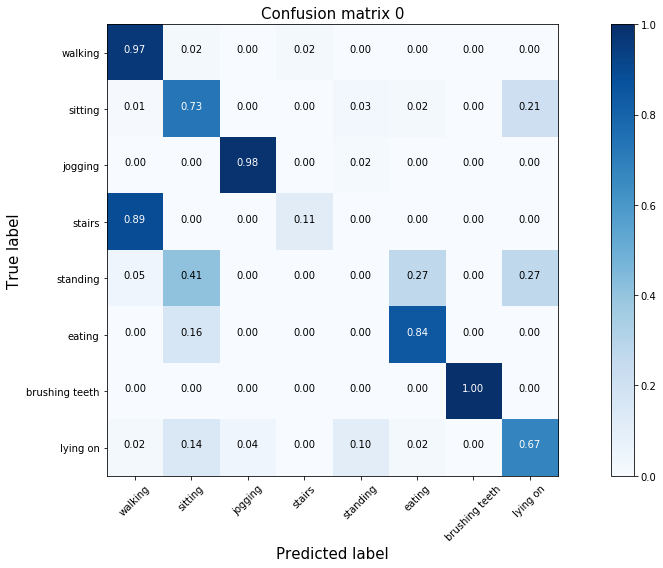

0.770949720670391
[[60  1  0  1  0  0  0  0]
 [ 1 75  0  0  3  2  0 22]
 [ 0  0 65  0  1  0  0  0]
 [ 8  0  0  1  0  0  0  0]
 [ 1  9  0  0  0  6  0  6]
 [ 0  5  0  0  0 27  0  0]
 [ 0  0  0  0  0  0 15  0]
 [ 1  7  2  0  5  1  0 33]]
(3590, 6)


/home/geo/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/geo/.local/lib/python3.6/site-packages/seglearn/transform.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for i in np.arange(N)])
/home/geo/.local/lib/python3.6/site-packages/seglearn/transform.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecat

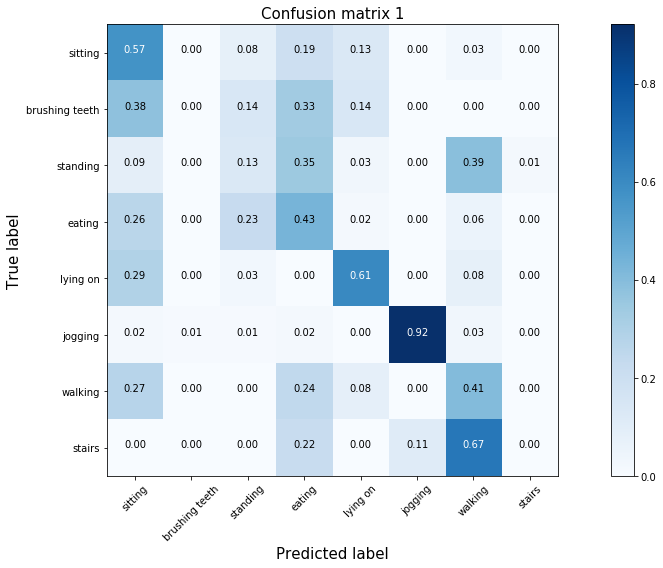

0.5348837209302325
[[ 44   0   6  15  10   0   2   0]
 [  8   0   3   7   3   0   0   0]
 [  6   0   9  24   2   0  27   1]
 [ 14   0  12  23   1   0   3   0]
 [ 11   0   1   0  23   0   3   0]
 [  2   1   1   2   0 116   4   0]
 [ 10   0   0   9   3   0  15   0]
 [  0   0   0   2   0   1   6   0]]
(6580, 6)


/home/geo/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/geo/.local/lib/python3.6/site-packages/seglearn/transform.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for i in np.arange(N)])
/home/geo/.local/lib/python3.6/site-packages/seglearn/transform.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecat

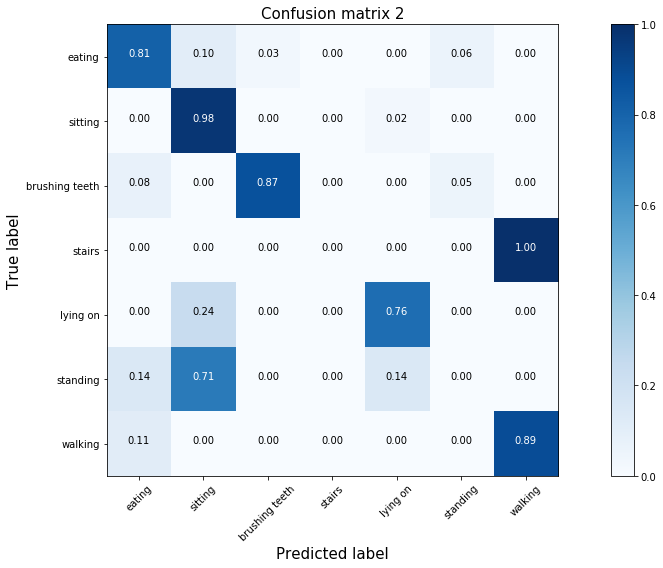

0.7735849056603774
[[ 55   7   2   0   0   4   0]
 [  0  40   0   0   1   0   0]
 [  3   0  34   0   0   2   0]
 [  0   0   0   0   0   0   2]
 [  0  84   0   0 273   0   0]
 [  2  10   0   0   2   0   0]
 [  1   0   0   0   0   0   8]]
(590, 6)


/home/geo/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/geo/.local/lib/python3.6/site-packages/seglearn/transform.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for i in np.arange(N)])


ValueError: n_components=80 must be between 0 and min(n_samples, n_features)=78 with svd_solver='full'

In [20]:
# This pipe is only for data transformations
transform_pipe = Pype([
    ("segment", best_estimator.named_steps["segment"]),
    ("features", best_estimator.named_steps["features"]),
    ("scaler", best_estimator.named_steps["scaler"]),
    ("pca", best_estimator.named_steps["pca"]),
], memory=None)

df_activities = pd.read_csv("./Data/HomoreDataFromVariousActivities/activities.csv")

cv = splitter.split(X, y, groups)
for fold, split in enumerate(cv):
    training_set, test_set = split
    
    # Spliting the to training and testing set
    x_train, x_test = np.asarray(X)[training_set], np.asarray(X)[test_set]
    y_train, y_test = np.asarray(y)[training_set], np.asarray(y)[test_set]
    
    visited = dict()
    labels = list()
    for yi_label in y_test:
        if yi_label not in visited:
            visited[yi_label] = True
            labels.append(yi_label)
    
    print(x_test[0].shape)
    # Transforming the test data to fit the model predictions
    _, y_test_trans = transform_pipe.fit_transform(x_test, y_test)
    
    # Fiting the model
    best_estimator.fit(x_train, y_train)
    
    # Predicting with trained model
    y_pred = best_estimator.predict(x_test)
    
    # Printing accuracy score and confusion matrix
    confusion_mat = confusion_matrix(y_test_trans, y_pred, labels=labels)
    clf_accuracy = accuracy_score(y_test_trans, y_pred)
    
    # Select the right labels and order them correcly
    labels_names = df_activities.loc[df_activities["ACTIVITY_ID"].isin(labels)]
    labels_names = labels_names.iloc[pd.Categorical(labels_names["ACTIVITY_ID"], categories = labels, ordered=True).argsort()]
    labels_names = labels_names["NAME"].to_list()
    plot_confusion_matrix(confusion_mat, labels_names, fold, normalize=True)
    
    print(clf_accuracy)
    print(confusion_mat)

# Dump and Load the model

In [24]:
best_estimator = best_estimator.fit(X, y)

/home/geo/.local/lib/python3.6/site-packages/seglearn/transform.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for i in np.arange(N)])


In [25]:
model_path = './Model/classifier.joblib'
dump(best_estimator, model_path) 

['./Model/classifier.joblib']

In [26]:
clf = load(model_path) 

In [30]:
dummy_data = np.random.rand(350, 6)
dummy_data = [dummy_data]

In [31]:
clf.predict(dummy_data)

array([102])

In [29]:
df_accel_gyro

,index,TIMESTAMP,ACCEL_X,ACCEL_Y,ACCEL_Z,GYRO_X,GYRO_Y,GYRO_Z,ACTIVITY_ID,USER_ID
0,0,2020-08-25 16:23:14.590,-1.230657,5.430215,7.670058,-1.084472,0.181100,-0.076701,107,0
1,1,2020-08-25 16:23:14.690,-1.743032,4.716721,8.117788,-1.465848,0.301478,-0.136357,107,0
2,2,2020-08-25 16:23:14.790,-2.229070,4.455745,8.960572,-1.877052,0.394159,-0.137423,107,0
3,3,2020-08-25 16:23:14.890,-2.496031,3.766193,9.097046,-1.774784,0.359005,-0.070309,107,0
4,4,2020-08-25 16:23:14.990,-2.711515,2.225478,9.026415,-2.076263,0.344090,-0.100138,107,0
...,...,...,...,...,...,...,...,...,...,...
460795,34795,2021-01-27 22:59:23.371,-9.205986,-2.050695,2.369134,0.025567,0.003196,-0.022370,103,5
460796,34796,2021-01-27 22:59:23.471,-9.183240,-2.038725,2.359557,0.012783,0.000000,-0.025567,103,5
460797,34797,2021-01-27 22:59:23.571,-9.261054,-2.062667,2.359557,-0.021305,-0.006392,-0.010653,103,5
460798,34798,2021-01-27 22:59:23.671,-9.233520,-1.977671,2.330826,-0.013848,0.000000,-0.010653,103,5
